In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
import evaluate
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import load_dataset

In [ ]:
df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

# Display the first few rows
print(df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                            question  \
0  Why whenever I get in the shower my girlfriend...   
1            What is a proxy, and how can I use one?   
2  What song has the lyrics "someone left the cak...   
3  I am the owner of an adult website called http...   
4  Does the Bible mention anything about a place ...   

                                              answer  
0  Isn’t it awful? You would swear that there was...  
1  A proxy server is a system or router that prov...  
2                                 MacArthur's Park\n  
3  Don't let apps that are liers put adds on your...  
4  St. John in the book of Revelation mentions an...  


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB
None


In [ ]:
print(df.describe())


                                                 question answer
count                                               56402  56402
unique                                               3234  54726
top     Would Hillary Clinton have made a better Presi...   No\n
freq                                                  106     89


In [ ]:
# Check for missing values
print(df.isnull().sum())

question    0
answer      0
dtype: int64


In [ ]:
# Length of questions
df['question_length'] = df['question'].apply(len)

# Length of answers
df['answer_length'] = df['answer'].apply(len)


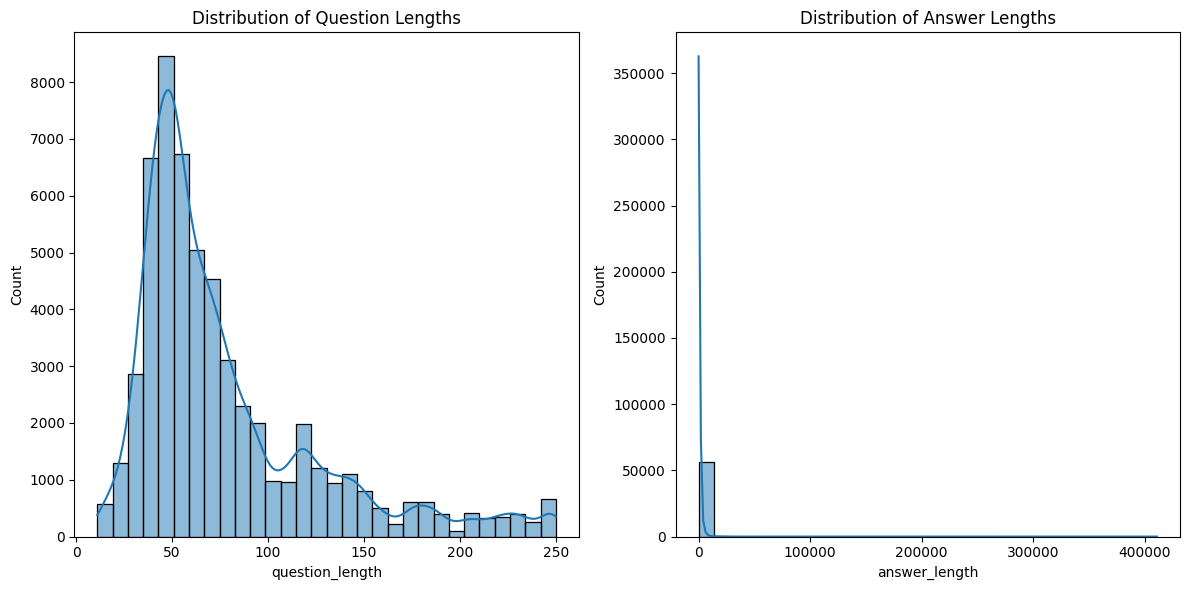

In [ ]:
plt.figure(figsize=(12, 6))

# Plot for question lengths
plt.subplot(1, 2, 1)
sns.histplot(df['question_length'], bins=30, kde=True)
plt.title('Distribution of Question Lengths')

# Plot for answer lengths
plt.subplot(1, 2, 2)
sns.histplot(df['answer_length'], bins=30, kde=True)
plt.title('Distribution of Answer Lengths')

plt.tight_layout()
plt.show()

In [ ]:
if 'is_duplicate' in df.columns:
    df.groupby("is_duplicate")['id'].count().plot.bar()
    plt.title('Distribution of Duplicate Questions')
    plt.xlabel('Is Duplicate')
    plt.ylabel('Count')
    plt.show()

In [ ]:
# Number of unique questions
unique_questions = df['question'].nunique()
print(f"Number of unique questions: {unique_questions}")

# Number of unique answers
unique_answers = df['answer'].nunique()
print(f"Number of unique answers: {unique_answers}")

Number of unique questions: 3234
Number of unique answers: 54726


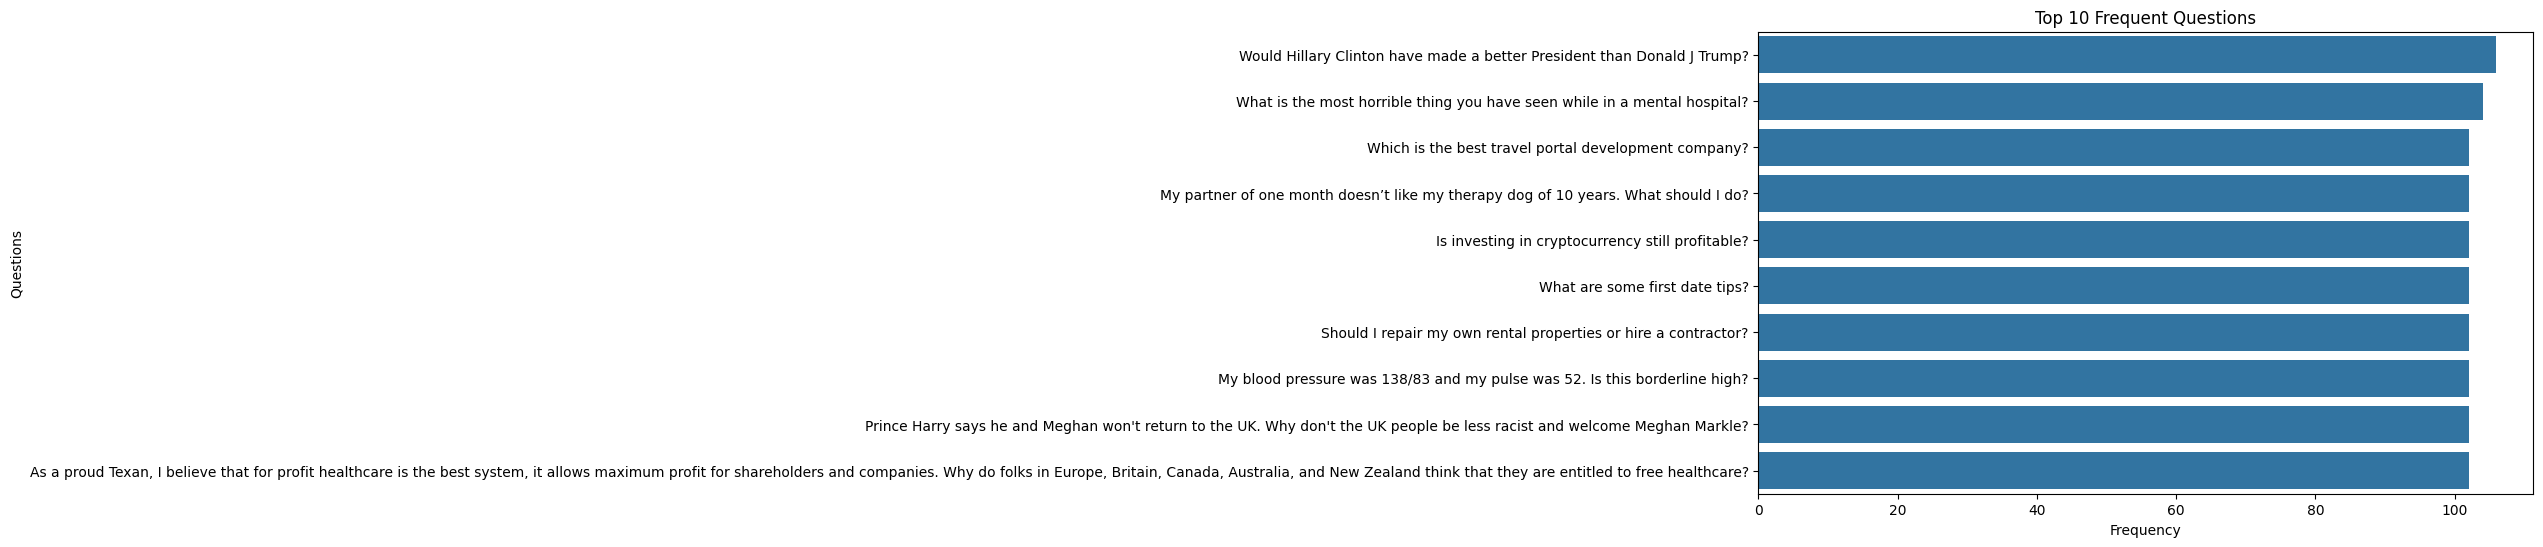

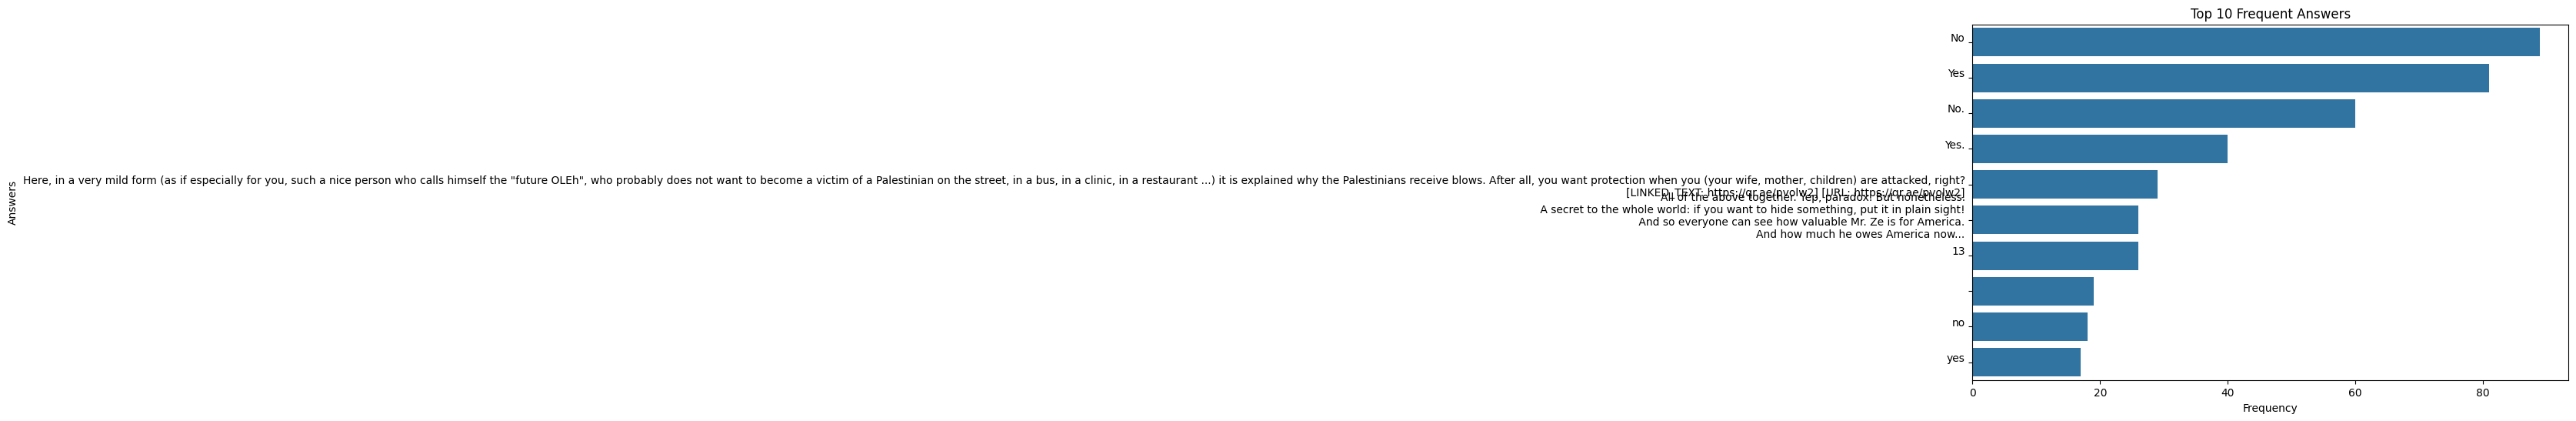

In [ ]:
# Top 10 frequent questions
top_questions = df['question'].value_counts().head(10)

# Plot top 10 frequent questions
plt.figure(figsize=(10, 6))
sns.barplot(x=top_questions.values, y=top_questions.index)
plt.title('Top 10 Frequent Questions')
plt.xlabel('Frequency')
plt.ylabel('Questions')
plt.show()

# Top 10 frequent answers
top_answers = df['answer'].value_counts().head(10)

# Plot top 10 frequent answers
plt.figure(figsize=(10, 6))
sns.barplot(x=top_answers.values, y=top_answers.index)
plt.title('Top 10 Frequent Answers')
plt.xlabel('Frequency')
plt.ylabel('Answers')
plt.show()

In [ ]:
duplicates = df.duplicated(subset=['question', 'answer'])
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 1220


In [ ]:
df_no_duplicates = df.drop_duplicates(subset=['question', 'answer'])

In [ ]:
# Check for duplicates based on 'question' only
duplicates_questions = df.duplicated(subset=['question'])
print(f"Number of duplicate questions: {duplicates_questions.sum()}")

# Check for duplicates based on 'answer' only
duplicates_answers = df.duplicated(subset=['answer'])
print(f"Number of duplicate answers: {duplicates_answers.sum()}")

Number of duplicate questions: 53168
Number of duplicate answers: 1676


In [ ]:
print(f"Number of rows after removing duplicates: {df_no_duplicates.shape[0]}")

Number of rows after removing duplicates: 55182


In [ ]:
df_no_duplicates.to_json("cleaned_no_duplicates_quora_data.jsonl", orient='records', lines=True)

In [ ]:
df_cleaned = pd.read_json("cleaned_no_duplicates_quora_data.jsonl", lines=True)


In [ ]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
# Define a function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Apply stemming
    stemmed_tokens = [ps.stem(word) for word in tokens]

    # Apply lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

# Apply preprocessing to the 'question' and 'answer' columns
df_cleaned['question_preprocessed'] = df_cleaned['question'].apply(preprocess_text)
df_cleaned['answer_preprocessed'] = df_cleaned['answer'].apply(preprocess_text)

# Display the first few rows of the preprocessed data
print(df_cleaned[['question_preprocessed', 'answer_preprocessed']].head())

                               question_preprocessed  \
0         whenever get shower girlfriend want join ?   
1                                  proxy , use one ?   
2          song lyric `` someone left cake rain '' ?   
3  owner adult website called http : //matureanal...   
4   Bible mention anything place `` '' heaven hell ?   

                                 answer_preprocessed  
0  ’ awful ? would swear ’ enough hot water go ar...  
1  proxy server system router provides gateway us...  
2                                  MacArthur 's Park  
3  n't let apps liers put add site . Like one say...  
4  St. John book Revelation mention address schol...  


In [ ]:
# Load and split the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")
dataset = dataset["train"].train_test_split(test_size=0.2)

# Load the tokenizer, model, and data collator
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Define preprocessing function
prefix = "answer the question: "

Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    labels = tokenizer(text_target=examples["answer"], max_length=512, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map preprocessing function across the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/11281 [00:00<?, ? examples/s]

In [ ]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=073a7d36af58707b97e82cdef3b559cc6ac8bab4c1e861e736fe7133dfa20dd7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
# Set up metrics for evaluation
nltk.download("punkt", quiet=True)
metric_rouge = evaluate.load("rouge")
metric_bleu = evaluate.load("bleu")
metric_em = evaluate.load("exact_match")

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Decode predictions and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE
    decoded_preds_rouge = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels_rouge = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    result_rouge = metric_rouge.compute(predictions=decoded_preds_rouge, references=decoded_labels_rouge, use_stemmer=True)

    # Compute BLEU
    decoded_preds_bleu = [pred.lower() for pred in decoded_preds]
    decoded_labels_bleu = [[label.lower()] for label in decoded_labels]  # BLEU expects a list of reference lists
    result_bleu = metric_bleu.compute(predictions=decoded_preds_bleu, references=decoded_labels_bleu)

    # Compute Exact Match (EM)
    result_em = metric_em.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        **result_rouge,
        "bleu": result_bleu['bleu'],
        "exact_match": result_em['exact_match']  # Ensure that exact_match is available
    }


In [28]:
# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    push_to_hub=False
)

# Set up trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./flan-t5-base-trained")
tokenizer.save_pretrained("./flan-t5-base-trained")

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Exact Match
1,3.179000,2.963521,0.113087,0.025008,0.092600,0.102404,0.000011,0.001507


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Exact Match
1,3.179000,2.963521,0.113087,0.025008,0.092600,0.102404,0.000011,0.001507
2,3.008600,2.919458,0.116656,0.026829,0.095945,0.106436,0.000014,0.001418


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


('./flan-t5-base-trained/tokenizer_config.json',
 './flan-t5-base-trained/special_tokens_map.json',
 './flan-t5-base-trained/spiece.model',
 './flan-t5-base-trained/added_tokens.json')

In [29]:
epochs = [1, 2]
training_loss = [3.179000, 3.008600]
validation_loss = [2.963521, 2.919458]
rouge1 = [0.113087, 0.116656]
rouge2 = [0.025008, 0.026829]
rougel = [0.092600, 0.095945]
rougelsum = [0.102404, 0.106436]
bleu = [0.000011, 0.000014]
exact_match = [0.001507, 0.001418]

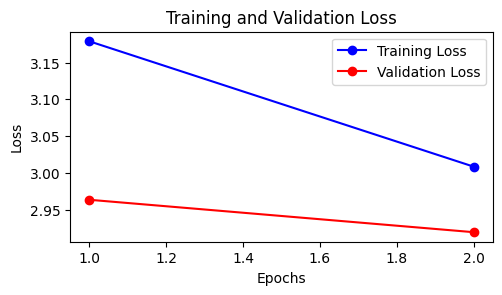

In [30]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

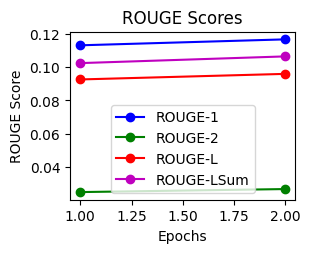

In [31]:
# Plot ROUGE Scores
plt.subplot(2, 2, 2)
plt.plot(epochs, rouge1, 'bo-', label='ROUGE-1')
plt.plot(epochs, rouge2, 'go-', label='ROUGE-2')
plt.plot(epochs, rougel, 'ro-', label='ROUGE-L')
plt.plot(epochs, rougelsum, 'mo-', label='ROUGE-LSum')
plt.xlabel('Epochs')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores')
plt.legend()